In [ ]:
# !pip install -q kaggle

In [ ]:
#from google.colab import files
#files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rohanchopra","key":"1e638ac489d4f79e45135d70278250f6"}'}

In [ ]:
#!rm -r ~/.kaggle
#!mkdir ~/.kaggle
#!cp /content/drive/MyDrive/Concordia/AAIProject/kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json
#!kaggle datasets list

In [ ]:
#!mkdir /content/kaggle_data/
#!kaggle datasets download nih-chest-xrays/data -p /content/kaggle_data/ --unzip

mkdir: cannot create directory ‘/content/kaggle_data/’: File exists
100% 42.0G/42.0G [05:18<00:00, 183MB/s]
100% 42.0G/42.0G [05:19<00:00, 141MB/s]
Traceback (most recent call last):
  File "/usr/lib/python3.7/zipfile.py", line 1691, in _extract_member
    shutil.copyfileobj(source, target)
  File "/usr/lib/python3.7/shutil.py", line 82, in copyfileobj
    fdst.write(buf)
OSError: [Errno 28] No space left on device

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/kaggle/cli.py", line 67, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 1287, in dataset_download_cli
    quiet=quiet)
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 1246, in dataset_download_files
    z.extractall(effective_path)

In [ ]:
#!kaggle datasets download redwankarimsony/chestxray8-dataframe -p /content/kaggle_data/ --unzip

  0% 0.00/51.3M [00:00<?, ?B/s]
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.7/dist-packages/kaggle/cli.py", line 67, in main
    out = args.func(**command_args)
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 1287, in dataset_download_cli
    quiet=quiet)
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 1236, in dataset_download_files
    self.download_file(response, outfile, quiet)
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 1599, in download_file
    out.write(data)
OSError: [Errno 28] No space left on device


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Sat Nov  5 17:19:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy.random import shuffle


import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.autograd.profiler as tprofiler

import torch.utils.data as td

import copy
import time
import random

from PIL import Image
from pathlib import Path

plt.rcParams["savefig.bbox"] = 'tight'

In [4]:
seed = 42

random.seed(seed)

# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
np.random.seed(seed)

In [8]:
!unzip /content/drive/MyDrive/AAI/data/resized_processed.zip -d /content/data/

Streaming output truncated to the last 5000 lines.
 extracting: /content/data/resized_processed/val/Mass/00011130_002.png  
 extracting: /content/data/resized_processed/val/Mass/00011130_005.png  
  inflating: /content/data/resized_processed/val/Mass/00011232_000.png  
  inflating: /content/data/resized_processed/val/Mass/00011237_027.png  
  inflating: /content/data/resized_processed/val/Mass/00011241_002.png  
  inflating: /content/data/resized_processed/val/Mass/00011355_001.png  
  inflating: /content/data/resized_processed/val/Mass/00011355_003.png  
  inflating: /content/data/resized_processed/val/Mass/00011355_036.png  
  inflating: /content/data/resized_processed/val/Mass/00011355_037.png  
  inflating: /content/data/resized_processed/val/Mass/00011355_040.png  
  inflating: /content/data/resized_processed/val/Mass/00011355_041.png  
  inflating: /content/data/resized_processed/val/Mass/00011355_042.png  
  inflating: /content/data/resized_processed/val/Mass/00011355_055.png  


In [9]:
base_dir = "/content/drive/MyDrive/AAI"
data_dir = '/content/drive/MyDrive/AAI/data'
images_dir = "/content/data/resized_processed"

In [10]:
train = pd.read_csv(os.path.join(data_dir,"train.csv"))
val = pd.read_csv(os.path.join(data_dir,"val.csv"))
test = pd.read_csv(os.path.join(data_dir,"test.csv"))

In [11]:
train.head(2)

,Patient ID,label,FilePath
0,2,No Finding,images_001/images/00000002_000.png
1,5,No Finding,images_001/images/00000005_003.png


In [12]:
def load_data(path, batch_size, input_size, norm_arr, 
              num_workers=0):
    
    ######## Write your code here ########
    
    transform_dict = {"train": 
                       T.Compose([
                        #T.ToPILImage(),
                        T.Resize(size=input_size),
                        
                        T.RandomHorizontalFlip(),
                        #T.ColorJitter(contrast=0.5),
                        T.RandomAdjustSharpness(2),
                        T.RandomAutocontrast(),
                        
                        T.ToTensor(),
                        T.Normalize(*norm_arr)]),
                      "test_val": 
                      T.Compose([
                         # T.ToPILImage(),
                        T.Resize(size=input_size),
                        T.ToTensor(),
                        T.Normalize(*norm_arr)])
                      }
    
    train_dataset = datasets.ImageFolder(root=os.path.join(path,"train"),
                                      transform=transform_dict["train"])
    val_dataset = datasets.ImageFolder(root=os.path.join(path,"val"),
                                      transform=transform_dict["test_val"])
    test_dataset = datasets.ImageFolder(root=os.path.join(path,"test"),
                                      transform=transform_dict["test_val"])
    
    data_loader_train = td.DataLoader(train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=False,
                                      num_workers=num_workers,
                                      pin_memory=True)
    data_loader_val = td.DataLoader(val_dataset,
                                      batch_size=batch_size,
                                      shuffle=False,
                                      drop_last=False,
                                      num_workers=num_workers,
                                    pin_memory=True)
    data_loader_test = td.DataLoader(test_dataset,
                                      batch_size=batch_size,
                                      shuffle=False,
                                      drop_last=False,
                                      num_workers=num_workers,
                                     pin_memory=True)
    
    return data_loader_train, data_loader_val, data_loader_test

In [13]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = dataiter.next()
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)), cmap='gray')

In [14]:
# Get best num_workers
# for i in range(97):
#   start = time.time()
#   data_loader_train, data_loader_val, data_loader_test = load_data(images_dir,
#                                                                   batch_size = 96, 
#                                                                   input_size = 299, 
#                                                                   norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
#                                                                   num_workers = i)

#   iter(data_loader_train).next()[0].shape
#   print(f"{i}: {time.time()-start}")

In [15]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [16]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
    norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    if model_name == "resnet":
        """ Resnet50
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 232
        norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    elif model_name == "vgg":
        """ VGG16_bn
        """
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 256
        norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
        norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    elif model_name == "mobile_net":
        """ 
        MOBILENET_V3_LARGE
        """
        model_ft = models.mobilenet_v3_large(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[3].in_features
        model_ft.classifier[3] = nn.Linear(num_ftrs, num_classes, bias=True)
        input_size = 232
        norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    elif model_name == "efficient_net_b1":
        """ 
        efficientnet_b1
        """
        model_ft = models.efficientnet_b1(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes, bias=True)

        input_size = 255
        norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    elif model_name == "efficient_net_b0":
        """ 
        efficientnet_b0
        """
        model_ft = models.efficientnet_b0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        model_ft.classifier[1] = nn.Linear(num_ftrs, num_classes, bias=True)
        
        input_size = 256
        norm_arr = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])


    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size, norm_arr

In [17]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "efficient_net_b0"

# Number of classes in the dataset
num_classes = 7

# Batch size for training (change depending on how much memory you have)
batch_size = 96

# Number of epochs to train for
num_epochs = 50

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False
# Initialize the model for this run
model_ft, input_size, norm_arr = initialize_model(model_name, num_classes, feature_extract, use_pretrained=False)

# Print the model we just instantiated
#print(model_ft)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [18]:
data_loader_train, data_loader_val, data_loader_test = load_data(images_dir,
                                                                 batch_size = batch_size, 
                                                                 input_size = input_size, 
                                                                 norm_arr = norm_arr,
                                                                 num_workers = 2)
data_loaders = {'train': data_loader_train,
                'val': data_loader_val}

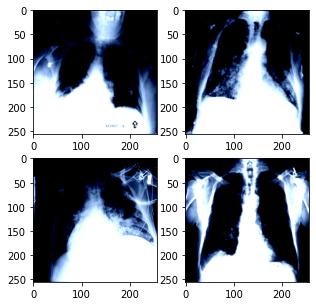

In [ ]:
plot_data_loader(data_loader_train, (2,2))

In [ ]:
plot_data_loader(data_loader_val, (2,2))

In [ ]:
plot_data_loader(data_loader_test, (2,2))

In [19]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False, profiler=False):
    since = time.time()

    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    prof = None

    total_steps = len(dataloaders['train'])

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            i = 0
            for inputs, labels in dataloaders[phase]:
                i+=1
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                #optimizer.zero_grad()
                for param in model.parameters():
                    param.grad = None

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        if profiler:
                            with tprofiler.profile(with_stack=True, profile_memory=True) as prof:
                                outputs, aux_outputs = model(inputs)
                        else:
                            outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        if profiler:
                              with tprofiler.profile(with_stack=True, profile_memory=True) as prof:
                                  outputs = model(inputs)
                        else:
                              outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                curr_loss = loss.item()
                running_loss += curr_loss * inputs.size(0)
                curr_acc = torch.sum(preds == labels.data)
                running_corrects += curr_acc

                if (i) % 100 == 0:
                    print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i}/{total_steps}], Loss: {curr_loss:.4f}, Accuracy: {curr_acc:.2f}%')


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            elif phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, prof, val_acc_history, val_loss_history, train_acc_history, train_loss_history

In [20]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001)

cuda:0
Params to learn:
	 features.0.0.weight
	 features.0.1.weight
	 features.0.1.bias
	 features.1.0.block.0.0.weight
	 features.1.0.block.0.1.weight
	 features.1.0.block.0.1.bias
	 features.1.0.block.1.fc1.weight
	 features.1.0.block.1.fc1.bias
	 features.1.0.block.1.fc2.weight
	 features.1.0.block.1.fc2.bias
	 features.1.0.block.2.0.weight
	 features.1.0.block.2.1.weight
	 features.1.0.block.2.1.bias
	 features.2.0.block.0.0.weight
	 features.2.0.block.0.1.weight
	 features.2.0.block.0.1.bias
	 features.2.0.block.1.0.weight
	 features.2.0.block.1.1.weight
	 features.2.0.block.1.1.bias
	 features.2.0.block.2.fc1.weight
	 features.2.0.block.2.fc1.bias
	 features.2.0.block.2.fc2.weight
	 features.2.0.block.2.fc2.bias
	 features.2.0.block.3.0.weight
	 features.2.0.block.3.1.weight
	 features.2.0.block.3.1.bias
	 features.2.1.block.0.0.weight
	 features.2.1.block.0.1.weight
	 features.2.1.block.0.1.bias
	 features.2.1.block.1.0.weight
	 features.2.1.block.1.1.weight
	 features.2.1.block

In [21]:
# 17 min 1 epoch - 128 batch size - inception
# Efficientnet b0 - batch 96 - epoch 50 - num_workers 2 - flip, auto cont, sharp - 

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, prof, val_acc_history, val_loss_history, train_acc_history, train_loss_history = train_model(model_ft, data_loaders, criterion, 
                             optimizer_ft, num_epochs=num_epochs, 
                             is_inception=(model_name=="inception"),
                             profiler=True)

Epoch 1/50
----------
Epoch [1/50], Step [100/407], Loss: 1.5854, Accuracy: 41.00%
Epoch [1/50], Step [200/407], Loss: 1.4839, Accuracy: 43.00%
Epoch [1/50], Step [300/407], Loss: 1.4890, Accuracy: 45.00%
Epoch [1/50], Step [400/407], Loss: 1.6317, Accuracy: 39.00%
train Loss: 1.5009 Acc: 0.4746
val Loss: 1.5204 Acc: 0.4737

Epoch 2/50
----------
Epoch [2/50], Step [100/407], Loss: 1.3535, Accuracy: 52.00%
Epoch [2/50], Step [200/407], Loss: 1.3981, Accuracy: 52.00%
Epoch [2/50], Step [300/407], Loss: 1.4253, Accuracy: 47.00%
Epoch [2/50], Step [400/407], Loss: 1.3685, Accuracy: 48.00%
train Loss: 1.4348 Acc: 0.4979
val Loss: 1.5071 Acc: 0.4739

Epoch 3/50
----------
Epoch [3/50], Step [100/407], Loss: 1.4114, Accuracy: 45.00%
Epoch [3/50], Step [200/407], Loss: 1.4723, Accuracy: 43.00%
Epoch [3/50], Step [300/407], Loss: 1.3951, Accuracy: 48.00%
Epoch [3/50], Step [400/407], Loss: 1.4112, Accuracy: 44.00%
train Loss: 1.4038 Acc: 0.5094
val Loss: 1.4415 Acc: 0.4974

Epoch 4/50
--------

In [ ]:
print(prof.key_averages(group_by_stack_n=5).table(sort_by='self_cpu_time_total', row_limit=50))

In [ ]:
val_acc_history

In [ ]:
val_loss_history

In [ ]:
train_acc_history

In [ ]:
train_loss_history

In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
vhist = []
vhist = [h.cpu().numpy() for h in val_acc_history]
thist = []
thist = [h.cpu().numpy() for h in train_acc_history]

plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
#plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),vhist,label="Validation")
plt.plot(range(1,num_epochs+1),thist,label="Training")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
vhist

In [ ]:
thist

In [ ]:
# Plot the training curves of validation accuracy vs. number
#  of training epochs for the transfer learning method and
#  the model trained from scratch
vhist = []
vhist = [h.cpu().numpy() for h in val_loss_history]
thist = []
thist = [h.cpu().numpy() for h in train_loss_history]

plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
#plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),vhist,label="Validation")
plt.plot(range(1,num_epochs+1),thist,label="Training")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
vhist

In [ ]:
thist

In [ ]:
torch.save(model_ft.state_dict(), 'Efficientnet_b0_batch_96_epoch_50_num_workers_2_flip_auto_cont_sharp_model_weights.pth')